# 1. Data and python environment

## 1.1. Copernicus Marine Service Hindcast marine wave stoke velocity dataset

Using CMEMS access it was downloaded the dataset with forcing variables (Stokes velocity vector) for the East mediterranean se in the date 2021-07-23 to 2021-08-12, accordin to the study conducted about the oil spills that occurred at the Syrian Baniyas Station in the Eastern Mediterranean on August 23, 2021 (DOI: 10.1016/j.marpolbul.2023.115887).
The data was downloaded using the browser access to Copernicus Marine Services, product id: MEDSEA_MULTIYEAR_WAV_006_012 - [data.marine.copernicus.eu](https://data.marine.copernicus.eu/product/MEDSEA_MULTIYEAR_WAV_006_012/download?dataset=med-hcmr-wav-rean-h_202411).

file is stored locally in the same folder of this notebook [med-hcmr-wav-rean-h_cyprus-aug-2021.nc](med-hcmr-wav-rean-h_cyprus-aug-2021.nc)



In [1]:
# check dataset downloaded
import xarray as xr
DS = xr.open_dataset('med-hcmr-wav-rean-h_cyprus-aug-2021.nc')
DS

<xarray.Dataset> Size: 85MB
Dimensions:    (time: 505, latitude: 127, longitude: 111)
Coordinates:
  * time       (time) datetime64[ns] 4kB 2021-08-23T23:00:00 ... 2021-09-13T2...
  * latitude   (latitude) float32 508B 32.9 32.94 32.98 ... 38.06 38.1 38.15
  * longitude  (longitude) float32 444B 31.71 31.75 31.79 ... 36.21 36.25 36.29
Data variables:
    VHM0       (time, latitude, longitude) float32 28MB ...
    VSDX       (time, latitude, longitude) float32 28MB ...
    VSDY       (time, latitude, longitude) float32 28MB ...
Attributes: (12/13)
    Conventions:       CF-1.11
    title:             Wave fields (2D) - Hourly Instantaneous
    institution:       Hellenic Centre for Marine Research (HCMR)- Athens,Greece
    producer:          CMEMS-MED Monitoring and Forecasting Centre
    source:            MEDWAM3
    credit:            Copernicus Marine Environment Monitoring Service (CMEMS)
    ...                ...
    references:        Please check in CMEMS catalogue the INFO section for p...
    comment:           Please check in CMEMS catalogue the INFO section for p...
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  MEDSEA_MULTIYEAR_WAV_006_012
    subset:datasetId:  med-hcmr-wav-rean-h_202411
    subset:date:       2025-07-03T07:30:49.259Z

## 1.2 Simulation data

To conduct the validation we used the following simulation data stored in [heco-validation-test.yaml](heco-validation-test.yaml).

```yaml
input:
  dataset_file_name: med-hcmr-wav-rean-h_cyprus-aug-2021.nc
  lat0: 
  lon0: 
  sim_diffusion_coeff: 
  sim_duration_h: 
  sim_particles: 
  sim_timedelta_s: 
  spill_release_duration_h: 
  time0: '2021-08-29 16:36:07'
  volume_spilled_m3: 



```


# 2. Run Simulation

Using a custom function we will run a Lagrangian model that simulate the emission of spill in a discrete step serie

In [2]:
import heco
output = heco.run('heco-validation-test.yaml')

Dataset med-hcmr-wav-rean-h_cyprus-aug-2021.nc opened
Renaming variable successful
Volume per particle considered: 10.0 m3
discrete spill step 0 , release time 2021-08-24 16:36:07
discrete spill step 1 , release time 2021-08-24 17:36:07
discrete spill step 2 , release time 2021-08-24 18:36:07
discrete spill step 3 , release time 2021-08-24 19:36:07
discrete spill step 4 , release time 2021-08-24 20:36:07
discrete spill step 5 , release time 2021-08-24 21:36:07
discrete spill step 6 , release time 2021-08-24 22:36:07
discrete spill step 7 , release time 2021-08-24 23:36:07
discrete spill step 8 , release time 2021-08-25 00:36:07
discrete spill step 9 , release time 2021-08-25 01:36:07
discrete spill step 10 , release time 2021-08-25 02:36:07
discrete spill step 11 , release time 2021-08-25 03:36:07


# 3. Store and visualize results

In the next steps we produce an html animated-map-viewer and a gif animation of simulation results.

## 3.1 CSV and GeoJSON particles time and positions

In [3]:
# save result to csv
output.to_csv('heco_results.csv', index=False)

# Save point to geojson with geopandas
import geopandas as gpd
gdf = gpd.GeoDataFrame(output, geometry=gpd.points_from_xy(output.lon, output.lat))
gdf.crs = "EPSG:4326"
gdf.to_file('heco_results.geojson', driver='GeoJSON')

print('Simulation results saved to heco_results.csv and heco_results.geojson')



Simulation results saved to heco_results.csv and heco_results.geojson


## 3.2 Plots

Now export gif animation and webmap

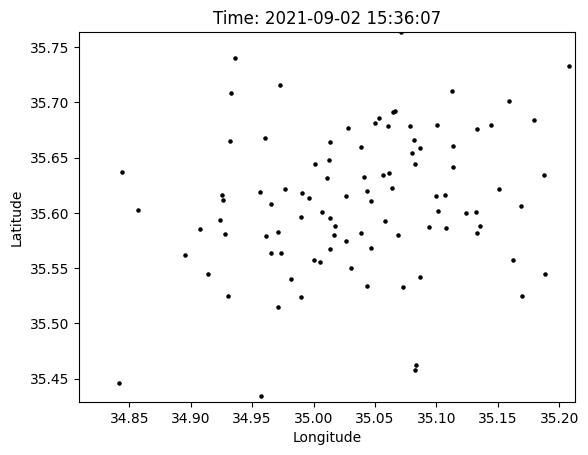

In [4]:

heco.create_points_animation('heco_results.geojson','heco_results.gif')

Generate a multistamp static plot with cartopy layer

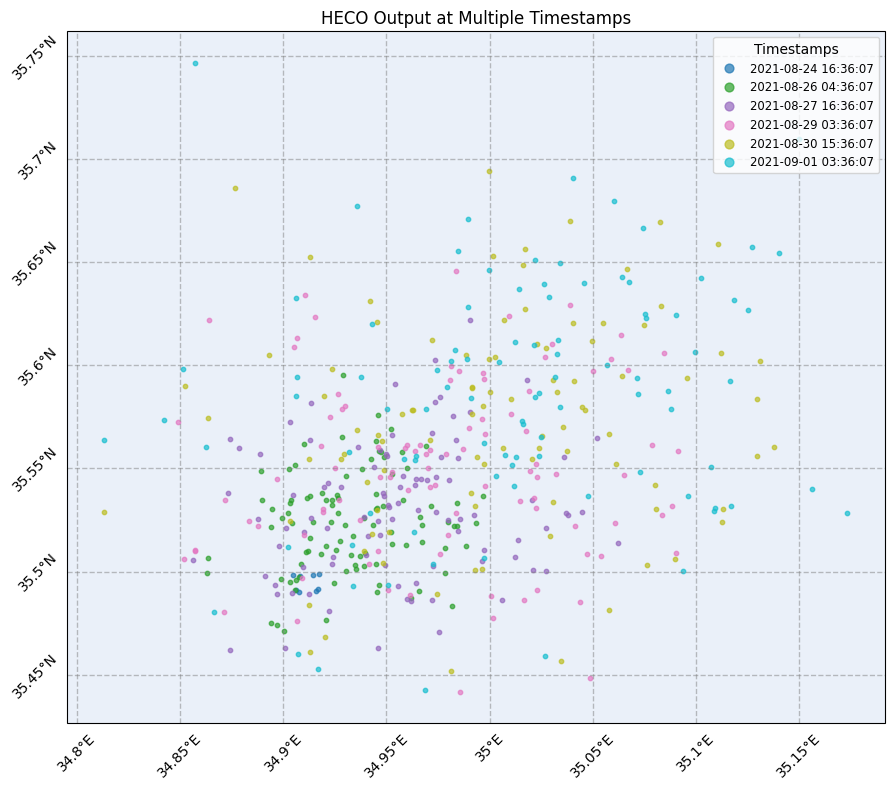

In [5]:
heco.multitimestamp_plot(output, 6)

## 3.3 Webmap and convex polygons

Using a custom function called `create_webmap`it is possible to generate an html that contain a LeafLet webmap and various EMODnet WMS Layers pre-configured.

It is also possible to pass the parameter `savepolygons = True` to convert points geometries in a convex-hull polygon that contain all particle for each time instant. This is a more efficent way to display and share the dispersions result across GIS user and map visualizers. The file will be saved in the default name `heco-polygons.geojson`

In [6]:
# export webmap

heco.create_webmap(
    HECOpoint_output_gdf_path = 'heco_results.geojson',
    EMODnetLayers = True,
    settingsFile_path = 'heco-validation-test.yaml',
    output_path = 'heco_map.html',
    savepolygons = True
)

GO to [heco_map.html](heco_map.html) to show the output